In [32]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [33]:

stock_data = pd.read_csv(r'C:\Users\jonna\Desktop\TKH\trading_simulation\data\s&p500_data.csv')

In [34]:
stock_data.index = pd.to_datetime(stock_data['Date'])
stock_data

stock_data = stock_data.drop(['Date'], axis='columns')
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000
...,...,...,...,...,...,...
2023-05-12,4138.540039,4143.740234,4099.120117,4124.080078,4124.080078,3533740000
2023-05-15,4126.649902,4141.250000,4110.270020,4136.279785,4136.279785,3562170000
2023-05-16,4127.950195,4135.540039,4109.859863,4109.899902,4109.899902,3654200000


Text(0, 0.5, 'Prices ($)')

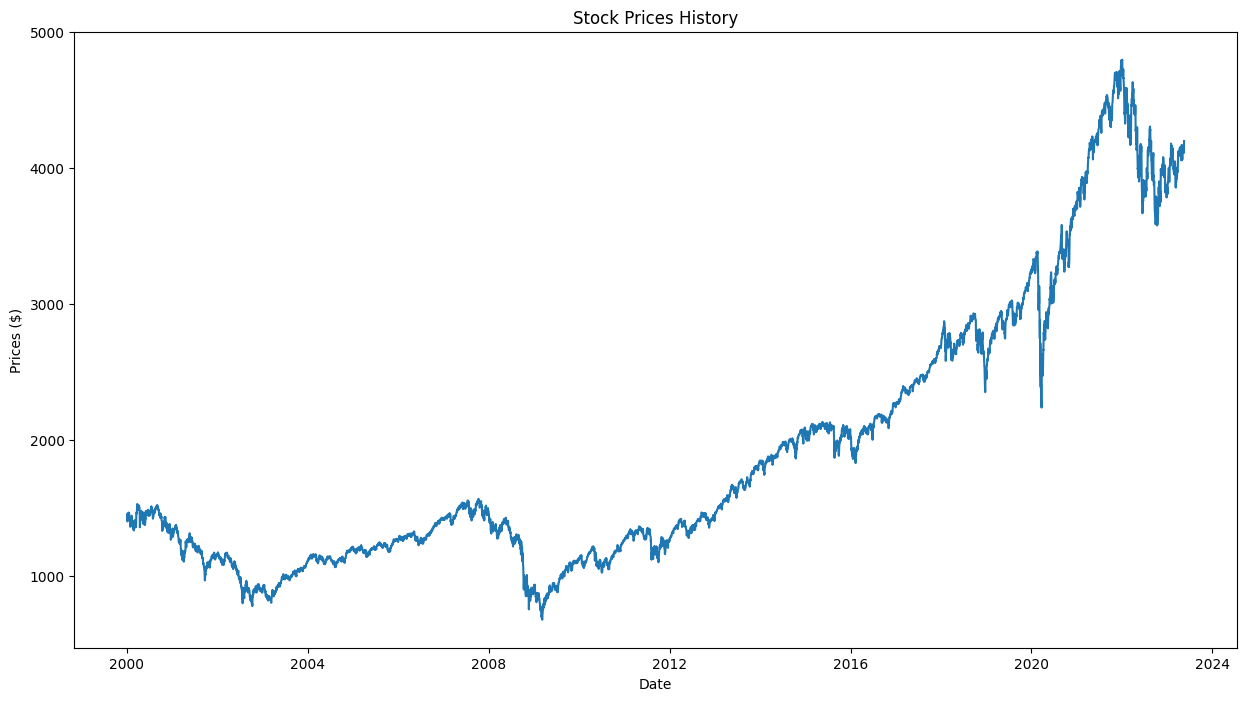

In [35]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [36]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [37]:
#Taking the 20% for testing
test_data = scaled_data[training_data_len-60: , : ]
x_test = []

#Creating the feature data(x_test) and label data (y_test)
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

#converting data to numpy 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [38]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()
# Show the summary of our LSTM network architecture.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 25)                2525      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
4645/4645 [==============================] - 40s 8ms/step - loss: 2.1045e-04
Epoch 2/3
4645/4645 [==============================] - 38s 8ms/step - loss: 1.1348e-04
Epoch 3/3
4645/4645 [==============================] - 38s 8ms/step - loss: 7.4414e-05


In [40]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

37/37 [==============================] - 1s 9ms/step


23.761247284558355

C:\Users\jonna\AppData\Local\Temp\ipykernel_12372\2205499952.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


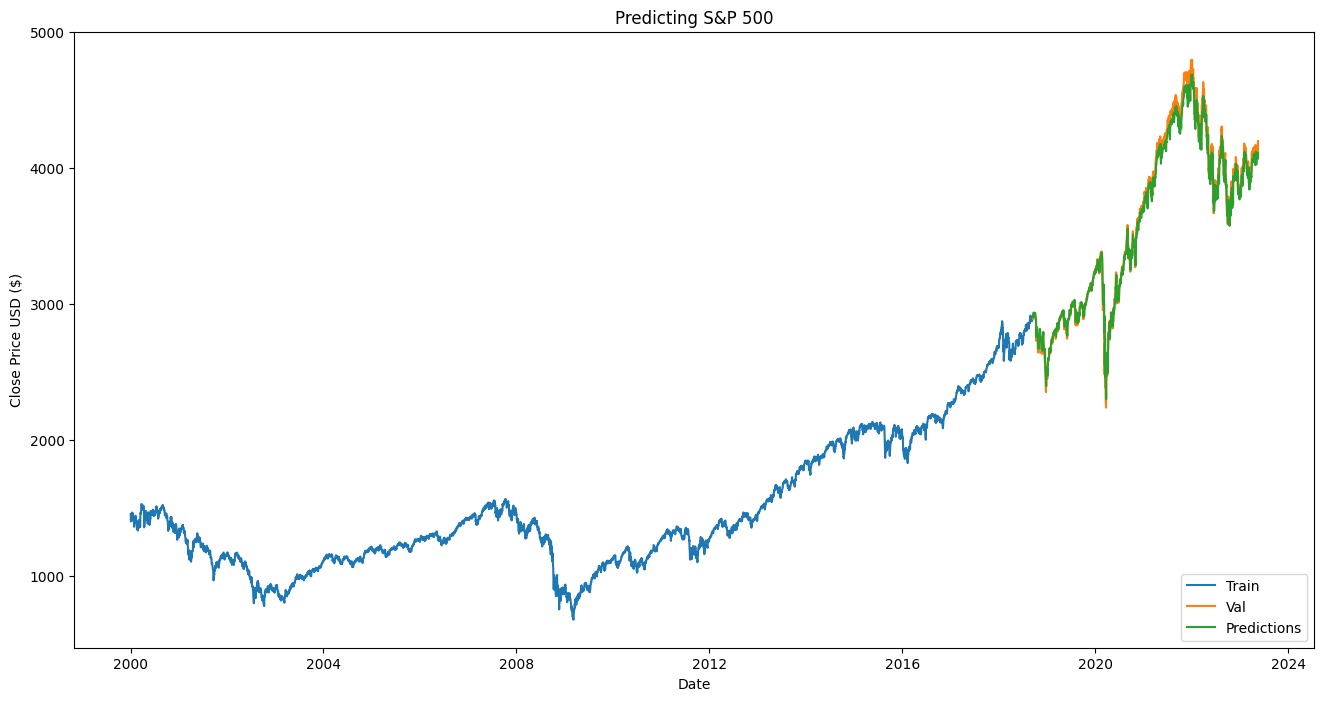

In [47]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Predicting S&P 500')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [31]:
validation

,Close,Predictions
Date,,
2018-09-17,2888.800049,2911.965332
2018-09-18,2904.310059,2896.116455
2018-09-19,2907.949951,2910.867676
2018-09-20,2930.750000,2914.210938
2018-09-21,2929.669922,2936.532471
...,...,...
2023-05-12,4124.080078,4134.090820
2023-05-15,4136.279785,4128.240234
2023-05-16,4109.899902,4139.449707
